# Part V: Window Functions in Spark

If you are familiar with relational databases and SQL, you have either used or at very least heard of Windowing and Window Functions.

Window functions are used to perform some kind of aggregation over a set of rows. The set of rows is called a Window.

Windows are a more advanced SQL technique but there is plently of documentation for different databases like [SQLServer](https://learn.microsoft.com/en-us/sql/t-sql/queries/select-window-transact-sql?view=sql-server-ver16) and [Oracle](https://docs.oracle.com/en/database/oracle/oracle-database/21/sqlrf/Analytic-Functions.html#GUID-527832F7-63C0-4445-8C16-307FA5084056)

The **OVER** clause is used with window functions to define the window we want to aggregate over. The OVER clause provides two things: 
- it partitions rows into form groups of rows using the **PARTITION BY** clause
- orders rows within partitions using the **ORDER BY** clause 

Syntax
```{sql}
SELECT coulmn_name1, 
 window_function(cloumn_name2)
 OVER([PARTITION BY column_name1] [ORDER BY column_name3]) AS new_column
FROM table_name;
```

**Data Scenario** <br>
We are going to use the market data we created in the first notebook for the exercises in this notebook. A financial analyst would be almost guaranteed to use Windowing at some point in their analysis.

A very common metric used to analyze financial data, is the daily return of an asset. This is the same as the percent change in closing price. 


We will show two different ways to accomplish this.
1. Using standard SQL
2. Using pyspark functions

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as func

spark = SparkSession.builder.appName("Window Functions").getOrCreate()

In [0]:
price_data = spark.sql(
    "SELECT Date, Close, Symbol FROM prices WHERE Date >'2022-04-01'"
)
price_data.createOrReplaceTempView('prev_yr_prices')
price_data.show(5)

+-------------------+-----------------+------+
|               Date|            Close|Symbol|
+-------------------+-----------------+------+
|2022-04-04 00:00:00|  782.22998046875|   BLK|
|2022-04-05 00:00:00|764.4299926757812|   BLK|
|2022-04-06 00:00:00|  745.22998046875|   BLK|
|2022-04-07 00:00:00|748.8900146484375|   BLK|
|2022-04-08 00:00:00|736.0999755859375|   BLK|
+-------------------+-----------------+------+
only showing top 5 rows



In [0]:
#build our sql window function
window_query = "ROUND((Close -  LAG(Close) OVER (PARTITION BY Symbol ORDER BY Date)) / LAG(Close) OVER (PARTITION BY Symbol ORDER BY Date) * 100, 2) as Return"

returns_df = spark.sql("SELECT Date, Symbol, " + window_query + " FROM prev_yr_prices")

In [0]:
returns_df.show(5)

+-------------------+------+------+
|               Date|Symbol|Return|
+-------------------+------+------+
|2022-04-04 00:00:00|   BLK|  null|
|2022-04-05 00:00:00|   BLK| -2.28|
|2022-04-06 00:00:00|   BLK| -2.51|
|2022-04-07 00:00:00|   BLK|  0.49|
|2022-04-08 00:00:00|   BLK| -1.71|
+-------------------+------+------+
only showing top 5 rows



Nice, we just calculated the daily return of the stocks in our portfolio and we can write it to a table and pass it along to the analysts. 

But if we can just do this with SQL why are we bothering with all the python? Well pyspark has a way to perform windowing as well. Let's see how this same calculation would look using pyspark functions.

In [0]:
# First we define a window partitioning by the asset symbol
window = Window.partitionBy("Symbol").orderBy("Date")

# Then we calculate the percent change for the closing price using the lag() function
returns = price_data.withColumn(
    "Return",
    func.round((func.col("Close") - func.lag(func.col("Close")).over(window))
    / func.lag(func.col("Close")).over(window) * 100, 2)
)

In [0]:
returns.select('Date', 'Symbol','Return').show(5)

+-------------------+------+------+
|               Date|Symbol|Return|
+-------------------+------+------+
|2022-04-04 00:00:00|   BLK|  null|
|2022-04-05 00:00:00|   BLK| -2.28|
|2022-04-06 00:00:00|   BLK| -2.51|
|2022-04-07 00:00:00|   BLK|  0.49|
|2022-04-08 00:00:00|   BLK| -1.71|
+-------------------+------+------+
only showing top 5 rows



And that's it! Now you know two ways to use windows in Spark to make calculations.

In [0]:
#see screenshot in readme; this cell only works in Databricks
#returns.display()

## Bonus

Ok to close out this course, the final exercise we will do is to calculate the moving average for our stocks. The moving average is the average closing price for a given time window. For example we can have a 2 day moving average (2MA), a 50 day moving average (50MA) and a 200 day moving average (200MA). 

The MA is one of the most popular technical indicators used in financial analytics. It helps understand the price trend by smoothing out fluctuation and spikes in the price. You can read more about it at [investopedia.](https://www.investopedia.com/terms/m/movingaverage.asp)

We will be calcuating the 50 day MA and 200 day MA.

To do this we will be using the `ROWS BETWEEN` clause.

In [0]:
moving_avg_df = spark.sql(
    "SELECT Date, Symbol, Close, "
    + "AVG(Close) OVER(PARTITION BY Symbol ORDER BY Date ROWS BETWEEN 49 PRECEDING AND CURRENT ROW) as 50MA, "
    + "AVG(Close) OVER(PARTITION BY Symbol ORDER BY Date ROWS BETWEEN 199 PRECEDING AND CURRENT ROW) as 200MA "
    + "FROM prev_yr_prices"
)

In [0]:
oracle_ma = moving_avg_df.filter('Symbol = "ORCL"').toPandas()

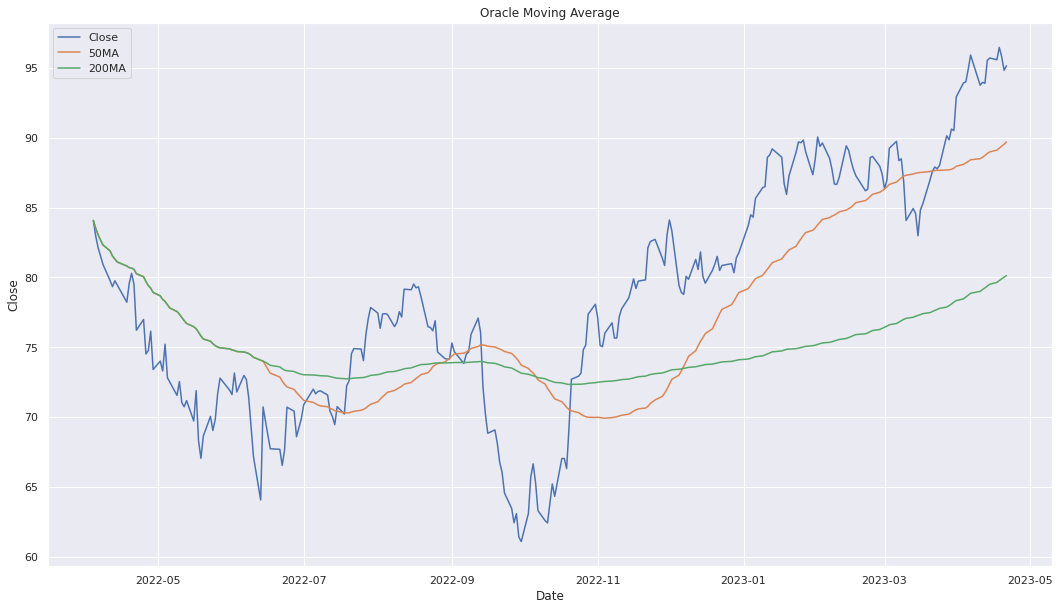

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,10))
# plot close
sns.lineplot( x = 'Date',
             y = 'Close',
             data = oracle_ma,
             label = 'Close')
  
# plot 50 day ma
sns.lineplot( x = 'Date',
             y = '50MA',
             data = oracle_ma,
             label = '50MA')

# plot 200 day ma
sns.lineplot( x = 'Date',
             y = '200MA',
             data = oracle_ma,
             label = '200MA')


plt.legend(loc='best')
plt.title('Oracle Moving Average')
sns.set_theme()

plt.show()

## Closing Remarks

And that's all folks. We have seen different ways we can use Spark with SQL commands and the python API to gather data from different sources, wrangle our data, and then perform complex calculations and analysis. We've also seen how the Databricks environment helps streamline the data delivery process and decrease the time insights for stakeholders.

Hopefully, what I've done has been helpful and at very least provide a starting point for others. This was a learning experience for me and i'm neither a finance expert nor a Spark expert so if there are any glaring mistakes please let me know on GitHub!


*Note: For the commented out sections that make use of display, I've included a few screenshots in the readme to help you see what the results look like*

In [0]:
# Run in Databricks to see results (screenshot in readme)
#oracle_ma.display()